In [ ]:
tfrom google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
ls

gdrive/  sample_data/


In [ ]:
cd /content/gdrive/MyDrive/PHD/SemEval2023/SemEval2022-Task10/re_run

/content/gdrive/MyDrive/PHD/SemEval2023/SemEval2022-Task10/private_space


In [ ]:
import pandas as pd

data = pd.read_csv("Data/starting_ki/train_all_tasks.csv")
# dfa = pd.read_csv("Data/dev_task_a_entries.csv")
# dfb = pd.read_csv("Data/dev_task_b_entries.csv")
# dfc = pd.read_csv("Data/dev_task_c_entries.csv")

In [ ]:
data

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none
...,...,...,...,...,...
13995,sexism2022_english-14185,complexes like the 'nice chicks' that go after...,sexist,2. derogation,2.1 descriptive attacks
13996,sexism2022_english-18629,"""GRAPHIC Germany - Muslim ""refugee"" stabbing h...",not sexist,none,none
13997,sexism2022_english-3320,Lol I imagine there would be simps that are li...,not sexist,none,none
13998,sexism2022_english-13309,"It's not, the girls I go on dates with don't k...",not sexist,none,none


In [ ]:
data[["text", "label_sexist"]].groupby("label_sexist").count()

,text
label_sexist,
not sexist,10602
sexist,3398


In [ ]:
label_values = data["label_sexist"].unique()
label_values

array(['not sexist', 'sexist'], dtype=object)

In [ ]:
texts = data['text'].values
labels = [1 if d=="sexist" else 0 for d in data['label_sexist'].values]

In [ ]:
text_lengths = [len(texts[i].split()) for i in range(len(texts))]
print(min(text_lengths))
print(max(text_lengths))

1
55


# Prepare Data

In [ ]:
!pip install -q transformers

In [ ]:
import transformers

In [ ]:
from transformers import BertTokenizer
from transformers import AutoModel, AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

print('Original Text: ', texts[0], '\n')
print('Tokenized Text: ', tokenizer.tokenize(texts[0]), '\n')
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Original Text:  Damn, this writing was pretty chaotic 

Tokenized Text:  ['Damn@@', ',', 'this', 'writing', 'was', 'pretty', 'chaotic'] 

Token IDs:  [56720, 7, 33, 1532, 38, 393, 31262]


In [ ]:
!pip3 install -q nltk emoji==0.6.0

In [ ]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


nltktokenizer = TweetTokenizer()


def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = nltktokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

In [ ]:
text_ids = [tokenizer.encode(text, max_length=100, padding='max_length', truncation=True) for text in texts]
# text_ids = [tokenizer.encode(normalizeTweet(text), max_length=100, padding='max_length', truncation=True) for text in texts]

In [ ]:
text_ids_lengths = [len(text_ids[i]) for i in range(len(text_ids))]
print(min(text_ids_lengths))
print(max(text_ids_lengths))


100
100


In [ ]:
att_masks = []
for ids in text_ids:
    masks = [int(id > 0) for id in ids]
    att_masks.append(masks)

In [ ]:
import torch
from sklearn.model_selection import train_test_split

train_x, test_val_x, train_y, test_val_y = train_test_split(text_ids, labels, random_state=42, test_size=0.2)
train_m, test_val_m = train_test_split(att_masks, random_state=42, test_size=0.2)

test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, random_state=42, test_size=0.5)
test_m, val_m = train_test_split(test_val_m, random_state=42, test_size=0.5)


## Convert to tensor
train_x = torch.tensor(train_x);
test_x = torch.tensor(test_x);
val_x = torch.tensor(val_x);
train_y = torch.tensor(train_y);
test_y = torch.tensor(test_y);
val_y = torch.tensor(val_y);
train_m = torch.tensor(train_m);
test_m = torch.tensor(test_m);
val_m = torch.tensor(val_m);

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## Load Model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification


num_labels = len(set(labels))

model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=num_labels, output_attentions=False, output_hidden_states=False)

print("#Label", num_labels)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

#Label 2


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(device)

cuda


In [ ]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print('Number of trainable parameters:', count_parameters(model), '\n', model)


In [ ]:
# model

## Fine-tune

In [ ]:
learning_rate = 1e-5
adam_epsilon = 1e-8

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
from transformers import get_linear_schedule_with_warmup

num_epochs = 5
total_steps = len(train_dataloader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [ ]:
import time
import numpy as np
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
# model

In [ ]:
from tqdm import tqdm
from sklearn.metrics import f1_score
import os

train_losses = []
val_losses = []
num_mb_train = len(train_dataloader)
num_mb_val = len(val_dataloader)

tmp_out_dir = f'./Models/_tmp_xx'
best_loss = None
best_epoch = -1

if num_mb_val == 0:
    num_mb_val = 1

for n in range(num_epochs):
    train_loss = 0
    start_time = time.time()
    
    for k, (mb_x, mb_m, mb_y) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        model.train()
        
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)
        
        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        loss = outputs[0]
        #loss = model_loss(outputs[1], mb_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.data / num_mb_train
    
    print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
    train_losses.append(train_loss.cpu())
    
    val_loss = 0
    with torch.no_grad():
        model.eval()
        
        eval_score = []
        for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
            mb_x = mb_x.to(device)
            mb_m = mb_m.to(device)
            mb_y = mb_y.to(device)
        
            outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
            
            loss = outputs[0]
        
            _, predicted_values = torch.max(outputs[1], 1)
            predicted_values = predicted_values.cpu().numpy()
            true_values = mb_y.cpu().numpy()

            f1 = f1_score(true_values, predicted_values, average='macro')
            eval_score.append(f1)

            
            val_loss += loss.data / num_mb_val
        
        _score = np.mean(eval_score)
        print ("Validation loss after itaration %i: loss:%f f1:%f" % (n+1, val_loss, _score))
        val_losses.append(val_loss.cpu())
        
        
        if best_loss is None or best_loss < _score:
            
            if not os.path.exists(tmp_out_dir):
                os.makedirs(tmp_out_dir)
                
            model.save_pretrained(tmp_out_dir)
            # tokenizer.save_pretrained(tmp_out_dir)

            best_loss = _score
            best_epoch = n
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Time: {epoch_mins}m {epoch_secs}s')

print("LOAD", best_epoch)
model = AutoModelForSequenceClassification.from_pretrained(tmp_out_dir)
model = model.to(device)

100%|██████████| 350/350 [03:06<00:00,  1.88it/s]



Train loss after itaration 1: 0.554951
Validation loss after itaration 1: loss:0.554538 f1:0.426724
Time: 3m 15s


100%|██████████| 350/350 [03:07<00:00,  1.86it/s]



Train loss after itaration 2: 0.492640
Validation loss after itaration 2: loss:0.455155 f1:0.669773
Time: 3m 16s


100%|██████████| 350/350 [03:07<00:00,  1.86it/s]



Train loss after itaration 3: 0.410104
Validation loss after itaration 3: loss:0.461645 f1:0.708956
Time: 3m 16s


100%|██████████| 350/350 [03:07<00:00,  1.87it/s]



Train loss after itaration 4: 0.371583
Validation loss after itaration 4: loss:0.444258 f1:0.720545
Time: 3m 16s


100%|██████████| 350/350 [03:08<00:00,  1.86it/s]



Train loss after itaration 5: 0.348828
Validation loss after itaration 5: loss:0.437661 f1:0.726799
Time: 3m 17s
LOAD 4


/content/gdrive/MyDrive/PHD/SemEval2023/SemEval2022-Task10/re_run


In [ ]:
import pickle
import os

out_dir = './Models/fine-tuned-bertweet'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)


('./Models/fine-tuned-bertweet/tokenizer_config.json',
 './Models/fine-tuned-bertweet/special_tokens_map.json',
 './Models/fine-tuned-bertweet/vocab.txt',
 './Models/fine-tuned-bertweet/bpe.codes',
 './Models/fine-tuned-bertweet/added_tokens.json')

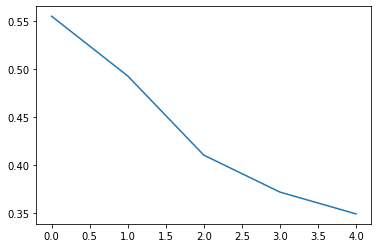

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)

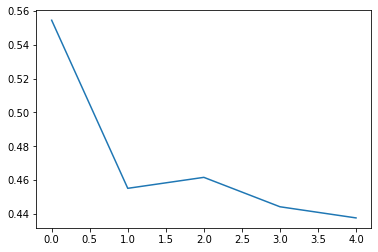

In [ ]:
plt.figure()
plt.plot(val_losses)

In [ ]:
# _model = model

## Run prediction

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

out_dir = './Models/fine-tuned-bertweet'

model = AutoModelForSequenceClassification.from_pretrained(out_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [ ]:
# model.classifier.out_proj.weight.sum(), _model.classifier.out_proj.weight.sum()

In [ ]:
batch_size = 32

test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []
with torch.no_grad():
    model.eval()
    for k, (mb_x, mb_m) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        output = model(mb_x, attention_mask=mb_m)
        outputs.append(output[0].to('cpu'))

outputs = torch.cat(outputs)


In [ ]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()


In [ ]:
sum(predicted_values)

324

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)
print("F1 Score:", f1_score(true_values, predicted_values, average="macro"))


print(classification_report(true_values, predicted_values, target_names=[str(l) for l in label_values]))


Test Accuracy: 0.81
F1 Score: 0.7401118272846291
              precision    recall  f1-score   support

  not sexist       0.86      0.89      0.87      1050
      sexist       0.63      0.58      0.61       350

    accuracy                           0.81      1400
   macro avg       0.75      0.73      0.74      1400
weighted avg       0.81      0.81      0.81      1400



In [ ]:
import itertools
from matplotlib import pyplot as plt

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[930 120]
 [146 204]]


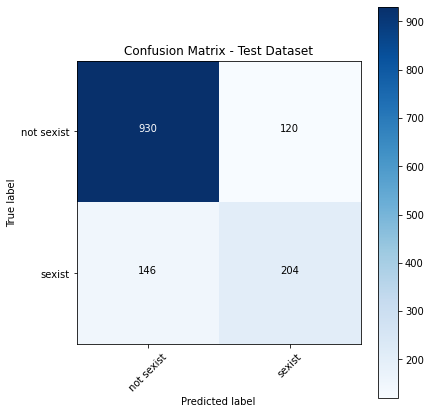

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
# plt.figure(figsize=(6,6))
# plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)


## Create Submissions

In [ ]:
traina = pd.read_csv("../Data/starting_ki/train_all_tasks.csv")
deva = pd.read_csv("../Data/dev_task_a_entries.csv")
testa = pd.read_csv("../Data/test_task_a_entries.csv")

In [ ]:
targetdf = testa
split = "test"
texts = targetdf['text'].values

In [ ]:
# text_ids = [tokenizer.encode(normalizeTweet(text), max_length=100, padding='max_length', truncation=True) for text in texts]
text_ids = [tokenizer.encode(text, max_length=100, padding='max_length', truncation=True) for text in texts]
att_masks = []
for ids in text_ids:
    masks = [int(id > 0) for id in ids]
    att_masks.append(masks)

test_x = torch.tensor(text_ids);
test_m = torch.tensor(att_masks);

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32
test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []
with torch.no_grad():
    model.eval()
    for k, (mb_x, mb_m) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        output = model(mb_x, attention_mask=mb_m)
        outputs.append(output[0].to('cpu'))

outputs = torch.cat(outputs)
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()

In [ ]:
label_map = {
    0: 'not sexist',
    1: 'sexist', 
    'not sexist':0,
    'sexist':1,
}

def number_to_label(label):
  return label_map[label]

predicted_labels = list(map(number_to_label, predicted_values))

In [ ]:
targetdf["label_pred"] = predicted_labels

In [ ]:
targetdf[["rewire_id", "label_pred"]].to_csv(f"Results/1a_bertweet_{split}.csv", index=False)